In [1]:
import os
import xarray as xr
import numpy as np

In [2]:
def regrid_vert(da, model = ''):                                                                                # does the same thing as scipy.interp1d, but quicker (can only be applied for models with 1D pressure coordinate)
    ''' Interpolate to common pressure levels (cloud fraction is dealt with separately)'''
    da['plev'] = da['plev'].round(0)                if model in ['ACCESS-ESM1-5', 'ACCESS-CM2'] else da['plev'] # plev coordinate is specified to a higher number of significant figures in these models
    p_new = np.array([100000, 92500, 85000, 70000, 60000, 50000, 40000, 30000, 25000, 20000, 15000, 10000, 7000, 5000, 3000, 2000, 1000, 500, 100])      

    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")
    da_p_new = da.interp(plev=p_new, method='linear', kwargs={'bounds_error':False, "fill_value": 0})    
    warnings.resetwarnings()
    return da_p_new

In [3]:
def get_era5_monthly(var, switch = {'ocean': False}):
    ''' Reanalysis data from ERA5 '''
    path_gen = f'/g/data/rt52/era5/pressure-levels/monthly-averaged/{var}'
    years = range(1998,2022)                                                # same years as for GPCP obs
    folders = [f for f in os.listdir(path_gen) if (f.isdigit() and int(f) in years)]
    folders = sorted(folders, key=int)
    path_fileList = []
    for folder in folders:
        path_folder = os.path.join(path_gen, folder)
        files = [f for f in os.listdir(path_folder) if f.endswith('.nc')]
        files = sorted(files, key=lambda x: x[x.index("l_")+1:x.index("-")])
        for file in files:
            path_fileList = np.append(path_fileList, os.path.join(path_folder, file))
    # print(path_fileList[0])
    ds = xr.open_mfdataset(path_fileList, combine='by_coords')
    # print(ds)
    ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    ds = ds.sortby('lat').sel(lat = slice(-35,35))
    da = ds[var]
    if 'level' in da.dims:
        da['level'] = da['level']*100                                       # convert from millibar (hPa) to Pa
        da = da.rename({'level': 'plev'})
        da = da.sortby('plev')
    da = regrid_vert(da)        if 'plev' in da.dims                else da # vertically interpolate
    ds = xr.Dataset(data_vars = {f'{var}': da.sel(lat=slice(-30,30))}, attrs = ds.attrs)
    return ds

In [4]:
hus = get_era5_monthly('q')['q']
zg = get_era5_monthly('z')['z']
ta = get_era5_monthly('t')['t']

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/share/proj failed


In [ ]:
c_p = 1.005     # specific heat capacity
L_v = 2.256e6   # latent heat of vaporization
da = ta + zg + hus
da

<xarray.DataArray (time: 288, plev: 19, lat: 241, lon: 1440)>
dask.array<add, shape=(288, 19, 241, 1440), dtype=float32, chunksize=(1, 19, 241, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75 30.0
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2021-12-01
  * plev     (plev) int64 100000 92500 85000 70000 60000 ... 2000 1000 500 100

In [ ]:
def calc_vMean(da, plevs0 = 850e2, plevs1 = 0):       # free troposphere (as most values at 1000 hPa  and 925 hPa over land are NaN)                              
    plevs = slice(plevs0, plevs1)
    da = da.sel(plev=plevs)
    w = ~np.isnan(da) * da['plev']                                  # Where there are no values, exclude the associated pressure levels from the weights
    da = (da * w).sum(dim='plev') / w.sum(dim='plev') 
    return da

In [ ]:
da_vMean = calc_vMean(da)
da_vMean

<xarray.DataArray (time: 288, lat: 241, lon: 1440)>
dask.array<truediv, shape=(288, 241, 1440), dtype=float64, chunksize=(1, 241, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75 30.0
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2021-12-01

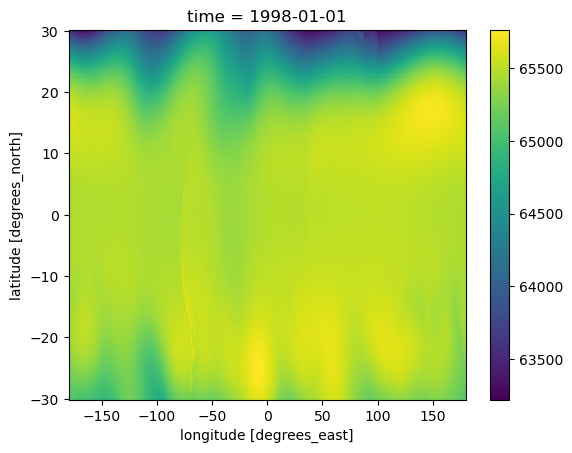

In [ ]:
da_vMean.isel(time=0).plot()